In [2]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image


In [3]:
IMAGE_PATH = r"C:\\Users\\LENOVO\\Desktop\\Data__"
IMAGE_SIZE = (224, 224)  # Image size for EfficientNetV2L
BATCH_SIZE = 32          # Batch size for processing
MODEL_PATH = "one_class_svm_model_v2l.pkl"


In [4]:
def load_images(image_path, image_size):
    image_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    images = []
    for file in image_files:
        img = load_img(file, target_size=image_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

print("Loading images...")
images = load_images(IMAGE_PATH, IMAGE_SIZE)
print(f"Loaded {len(images)} images.")


Loading images...
Loaded 3491 images.


In [5]:
print("Extracting features using EfficientNetV2L...")
base_model = EfficientNetV2L(weights='imagenet', include_top=False, pooling='avg')
features = base_model.predict(images, batch_size=BATCH_SIZE)


Extracting features using EfficientNetV2L...
110/110 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step


In [6]:
np.save("efficientnet_features.npy", features)
print("Features saved successfully!")


Features saved successfully!


In [7]:
loaded_features = np.load("efficientnet_features.npy")
print(f"Loaded features shape: {loaded_features.shape}")


Loaded features shape: (3491, 1280)


In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(loaded_features)

# Save the StandardScaler
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

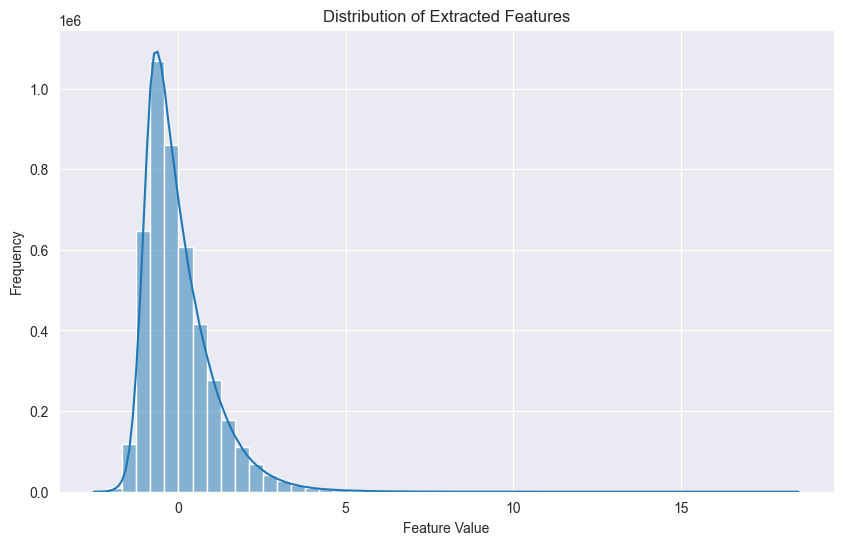

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(scaled_features.flatten(), bins=50, kde=True)
plt.title("Distribution of Extracted Features")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.show()


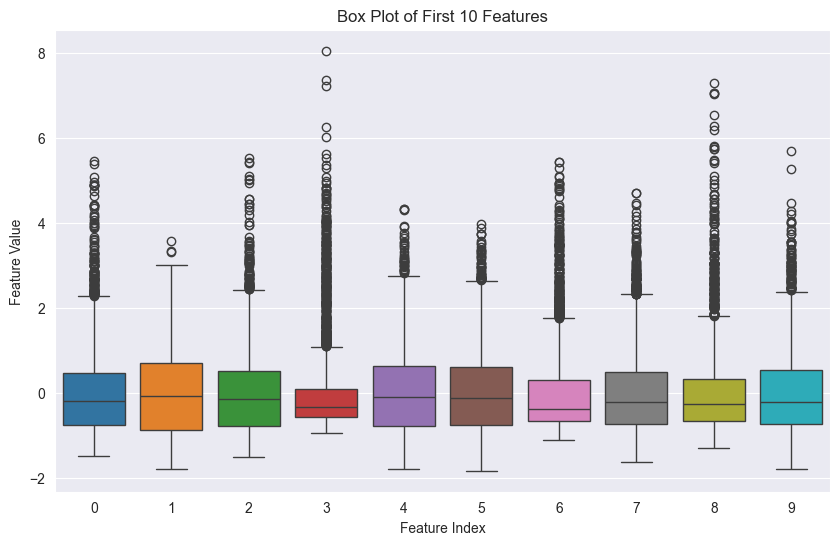

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scaled_features[:, :10])  # Showing first 10 features
plt.title("Box Plot of First 10 Features")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

Text(0, 0.5, 't-SNE Component 2')

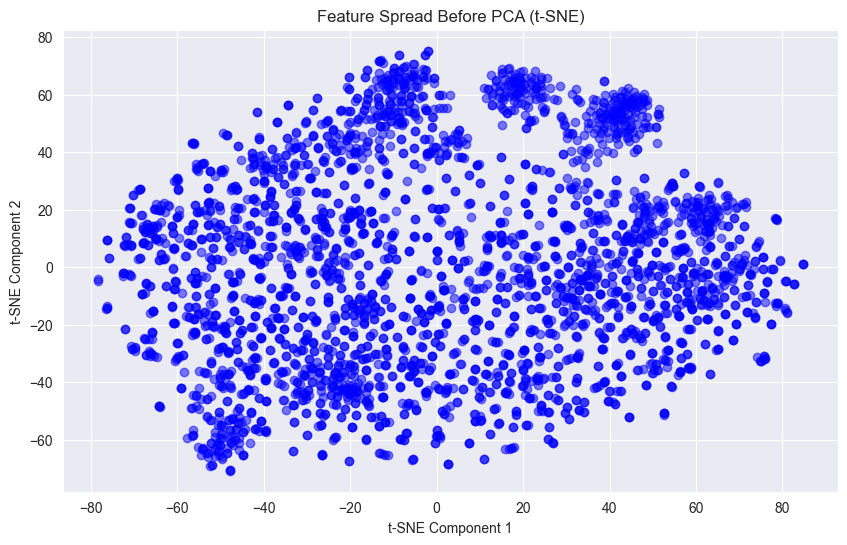

In [11]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], alpha=0.5, color='blue')
plt.title("Feature Spread Before PCA (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

In [12]:
pca = PCA()
pca.fit(scaled_features)

PCA()

In [13]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)  # Cumulative sum
num_components = np.argmax(explained_variance >= 0.95) + 1  # Find components needed for 95% variance

print(f"Optimal Number of Components to Retain 95% Variance: {num_components}")


Optimal Number of Components to Retain 95% Variance: 344


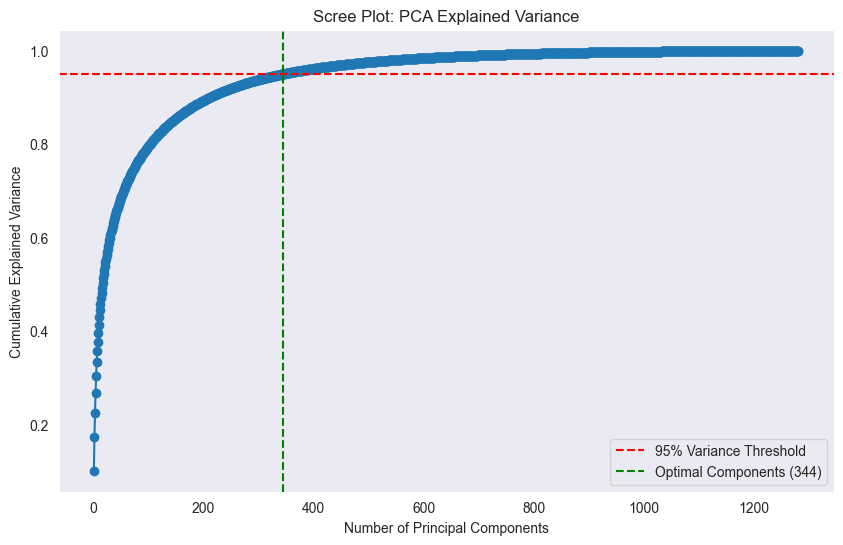

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
plt.axvline(x=num_components, color='g', linestyle='--', label=f"Optimal Components ({num_components})")

plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot: PCA Explained Variance")
plt.legend()
plt.grid()
plt.show()


In [15]:
pca = PCA(n_components=num_components)  # Retain 95% variance
reduced_features = pca.fit_transform(scaled_features)

print(f"Reduced Feature Shape: {reduced_features.shape}")

# Save PCA Model & Transformed Features
joblib.dump(pca, "pca_model.pkl")
np.save("pca_reduced_features.npy", reduced_features)

Reduced Feature Shape: (3491, 344)


In [16]:
minmax_scaler = MinMaxScaler()
normalized_features = minmax_scaler.fit_transform(reduced_features)
print(f"Final Feature Shape After Normalization: {normalized_features.shape}")

Final Feature Shape After Normalization: (3491, 344)


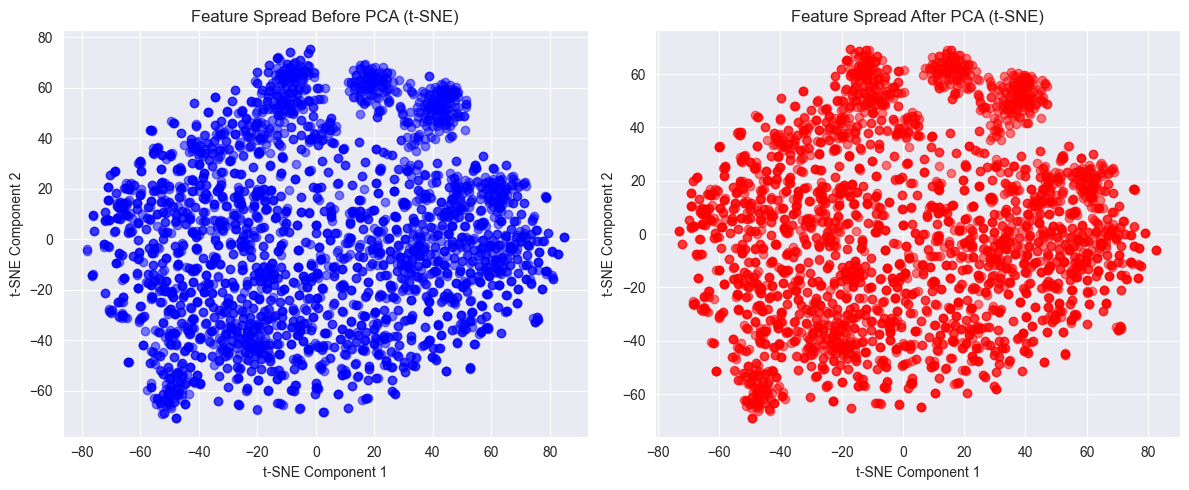

In [17]:


tsne_features_before = tsne.fit_transform(scaled_features)  # Original
tsne_features_after = tsne.fit_transform(reduced_features)  # PCA reduced

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(tsne_features_before[:, 0], tsne_features_before[:, 1], alpha=0.5, color='blue')
plt.title("Feature Spread Before PCA (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.subplot(1, 2, 2)
plt.scatter(tsne_features_after[:, 0], tsne_features_after[:, 1], alpha=0.5, color='red')
plt.title("Feature Spread After PCA (t-SNE)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

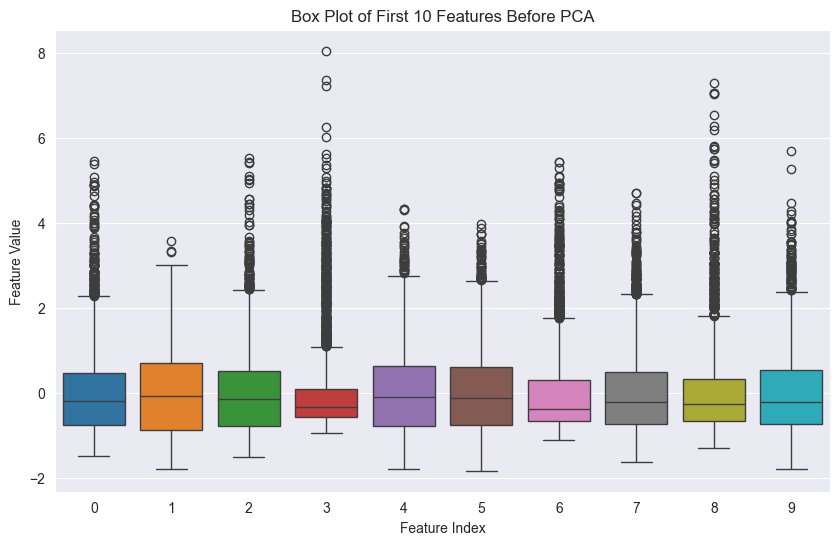

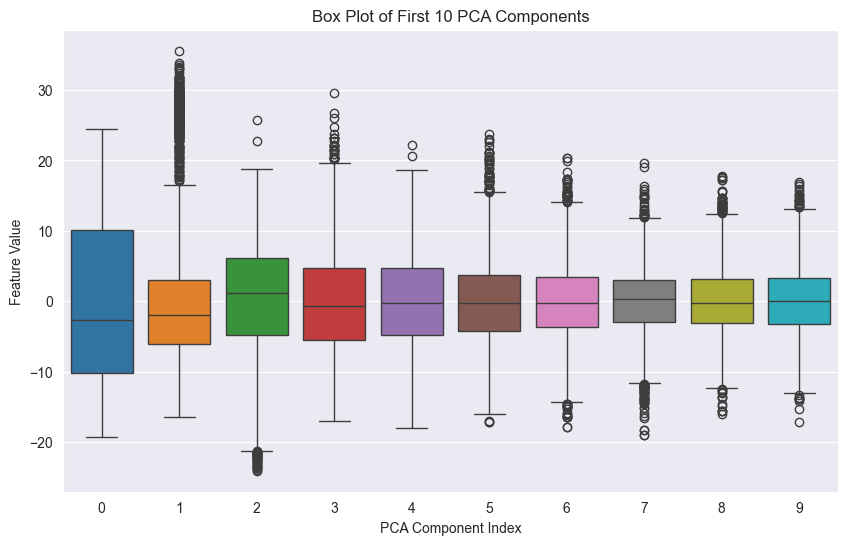

In [18]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=scaled_features[:, :10])  # Showing first 10 features
plt.title("Box Plot of First 10 Features Before PCA")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=reduced_features[:, :10])  # First 10 PCA components
plt.title("Box Plot of First 10 PCA Components")
plt.xlabel("PCA Component Index")
plt.ylabel("Feature Value")
plt.show()


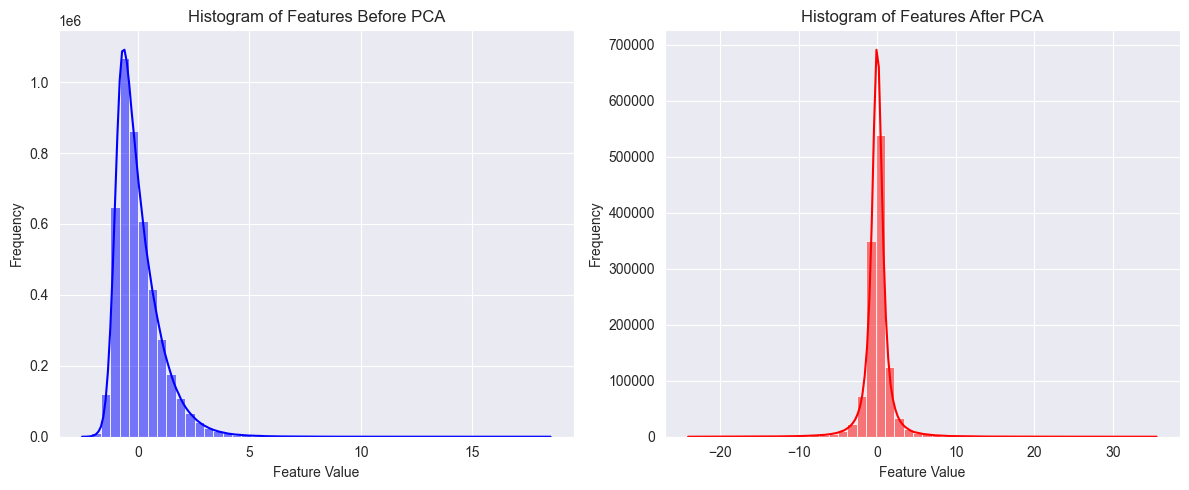

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(scaled_features.flatten(), bins=50, kde=True, color="blue")
plt.title("Histogram of Features Before PCA")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(reduced_features.flatten(), bins=50, kde=True, color="red")
plt.title("Histogram of Features After PCA")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [20]:
# Save MinMaxScaler & Normalized Features
joblib.dump(minmax_scaler, "minmax_scaler.pkl")
np.save("normalized_features.npy", normalized_features)

In [21]:

print("Training One-Class SVM model...")


def oc_svm_score(model, X):
    return np.mean(model.decision_function(X))


oc_svm_scorer = make_scorer(oc_svm_score, greater_is_better=True)

param_grid = {'nu': [0.01, 0.05, 0.1], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear']}

grid = GridSearchCV(OneClassSVM(), param_grid, cv=3, n_jobs=-1, scoring=oc_svm_scorer)
grid.fit(normalized_features)  # Use normalized features

best_oc_svm = grid.best_estimator_
print("Best parameters:", grid.best_params_)

best_oc_svm.fit(normalized_features)
print("One-Class SVM training complete.")

# Save trained One-Class SVM model
joblib.dump(best_oc_svm, "ocsvm_model.pkl")

Training One-Class SVM model...


C:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}
One-Class SVM training complete.


['ocsvm_model.pkl']

In [22]:
# Ensure model parameters use numpy.float64
best_oc_svm.support_vectors_ = np.array(best_oc_svm.support_vectors_, dtype=np.float64)
best_oc_svm.dual_coef_ = np.array(best_oc_svm.dual_coef_, dtype=np.float64)

# Save the fixed model
joblib.dump(best_oc_svm, MODEL_PATH)
print(f"Model re-saved to {MODEL_PATH}")


Model re-saved to one_class_svm_model_v2l.pkl


In [23]:
def preprocess_image(image_path):
    """Load and preprocess an image for EfficientNet."""
    img = image.load_img(image_path, target_size=(224, 224))  # EfficientNet Input Size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)  # Normalize input

In [24]:
def predict(image_path, base_model):
    """Extract features, apply PCA, normalize, and predict using One-Class SVM."""

    # Load saved models
    pca = joblib.load("pca_model.pkl")
    scaler = joblib.load("scaler.pkl")
    minmax_scaler = joblib.load("minmax_scaler.pkl")
    oc_svm = joblib.load("ocsvm_model.pkl")

    # Preprocess image
    img_array = preprocess_image(image_path)

    # Extract features using EfficientNet
    feature = base_model.predict(img_array)

    # Standardize using the same scaler used in training
    feature_scaled = scaler.transform(feature)

    # Apply PCA transformation
    feature_pca = pca.transform(feature_scaled)

    # Apply MinMax Scaling
    feature_normalized = minmax_scaler.transform(feature_pca)

    # Predict using One-Class SVM
    prediction = oc_svm.predict(feature_normalized)

    return "Normal" if prediction[0] == 1 else "Anomaly"


In [30]:

test_image_path = r"C:\\Users\\LENOVO\\Desktop\\DSGP_\\New folder\\Untitled46.jpg"
if os.path.isfile(test_image_path):
    print(f"Testing single image: {test_image_path}")
    result = predict(test_image_path, base_model)
    print(f"Image: {test_image_path} -> Prediction: {result}")


Testing single image: C:\\Users\\LENOVO\\Desktop\\DSGP_\\New folder\\Untitled46.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Image: C:\\Users\\LENOVO\\Desktop\\DSGP_\\New folder\\Untitled46.jpg -> Prediction: Anomaly
